In [37]:
!pip install -q medmnist

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.1 MB/s eta 0:00:00


In [38]:
# ---------------- Hyperparameters ----------------
T = 200
img_size = 28
batch_size = 128
num_epochs = 2
lr = 2e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [39]:
# ---------------- Diffusion schedule ----------------
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

In [40]:
# ---------------- Sinusoidal time embedding ----------------
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin1 = nn.Linear(dim, dim * 4)
        self.lin2 = nn.Linear(dim * 4, dim * 4)

    def forward(self, t):
        half = self.dim // 2
        device = t.device

        freq = math.log(10000) / (half - 1)
        freq = torch.exp(torch.arange(half, device=device) * -freq)
        angles = t.float().unsqueeze(1) * freq.unsqueeze(0)

        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))

        x = F.silu(self.lin1(emb))
        x = F.silu(self.lin2(x))
        return x

In [41]:
# ---------------- Simple U-Net ----------------
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=32, time_dim=32):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)
        time_out = time_dim * 4

        ch = base_channels
        self.conv1 = nn.Conv2d(in_channels, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.down = nn.Conv2d(ch, ch * 2, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(ch * 2, ch * 2, 3, padding=1)

        self.up = nn.ConvTranspose2d(ch * 2, ch, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(ch, ch, 3, padding=1)
        self.out_conv = nn.Conv2d(ch, in_channels, 3, padding=1)

        self.time_proj1 = nn.Linear(time_out, ch)
        self.time_proj2 = nn.Linear(time_out, ch * 2)

    def forward(self, x, t):
        temb = self.time_mlp(t)
        b = x.size(0)

        h1 = F.relu(self.conv1(x))
        h1 = h1 + self.time_proj1(temb).view(b, -1, 1, 1)
        h1 = F.relu(self.conv2(h1))

        h2 = F.relu(self.down(h1))
        h2 = h2 + self.time_proj2(temb).view(b, -1, 1, 1)
        h2 = F.relu(self.conv3(h2))

        h3 = F.relu(self.up(h2))
        h3 = h3 + h1
        h3 = F.relu(self.conv4(h3))

        return self.out_conv(h3)

In [42]:
# ---------------- Diffusion utilities ----------------
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    a_bar = alpha_bars.to(x0.device)[t].view(-1, 1, 1, 1)
    return torch.sqrt(a_bar) * x0 + torch.sqrt(1 - a_bar) * noise, noise

@torch.no_grad()
def p_sample(model, x_t, t):
    b = x_t.size(0)
    t_batch = torch.full((b,), t, device=x_t.device, dtype=torch.long)

    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]

    eps_theta = model(x_t, t_batch)
    mean = (1 / torch.sqrt(alpha_t)) * (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps_theta)

    if t == 0:
        return mean
    return mean + torch.sqrt(beta_t) * torch.randn_like(x_t)

@torch.no_grad()
def p_sample_loop(model, shape):
    x = torch.randn(shape, device=device)
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    return x

In [48]:
# ---------------- Load PathMNIST ----------------
data_flag = "pathmnist"
info = INFO[data_flag]
DataClass = getattr(medmnist, info["python_class"])

# Define a transform to convert images to tensors and normalize them
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # Normalize to [-1, 1]
])

train_ds = DataClass(split="train", download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [44]:
# ---------------- Model & optimizer ----------------
model = SimpleUNet(in_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [49]:
# ---------------- Training ----------------
losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for step, (x0, _) in enumerate(train_loader):
        x0 = x0.to(device)

        b = x0.size(0)
        t = torch.randint(0, T, (b,), device=device)

        x_t, noise = q_sample(x0, t)
        pred_noise = model(x_t, t)

        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if step >= 50:
            break

    avg_loss = epoch_loss / (step + 1)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}")

Epoch 1/2 - loss: 0.9114
Epoch 2/2 - loss: 0.5262


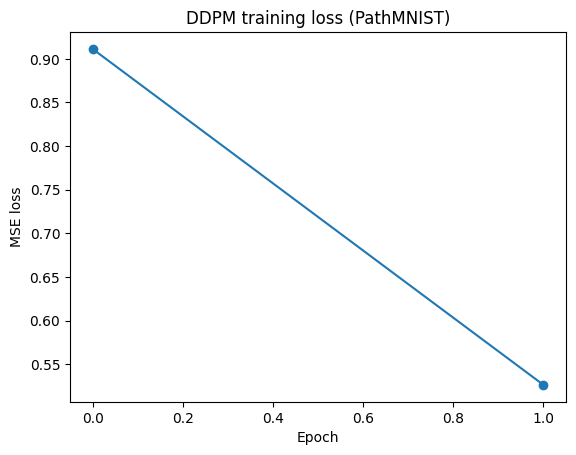

In [50]:
# ---------------- Plot loss ----------------
plt.plot(losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("DDPM training loss (PathMNIST)")
plt.show()

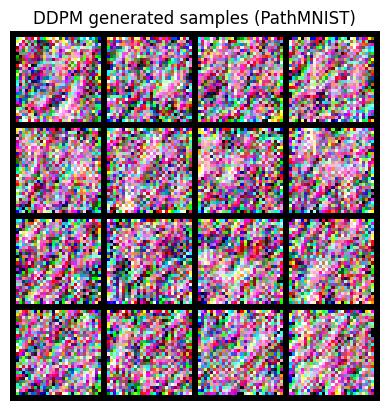

In [51]:
# ---------------- Generate samples ----------------
model.eval()
with torch.no_grad():
    samples = p_sample_loop(model, (16, 3, img_size, img_size))
    samples = (samples.clamp(-1, 1) + 1) / 2

grid = make_grid(samples, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("DDPM generated samples (PathMNIST)")
plt.show()

Git Repository

https://github.com/sjk07-k/DDPM.git